In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import random
%matplotlib inline

In [82]:
Mnist_df = pd.read_csv("ex3_train.csv")
# Alternative way of doing -----Mnist_df_train_data = Mnist_df.as_matrix(columns=Mnist_df.columns[0:400])
Mnist_df_train_data = Mnist_df.values
Mnist_df_train_label = Mnist_df.as_matrix(columns=Mnist_df.columns[400:401])
#Mnist_df_train_data_with_bias = np.c_[np.ones((Mnist_df_train_data.shape[0] ,1)),Mnist_df_train_data]## Add 1 for the bias

In [83]:
Mnist_df_test = pd.read_csv("ex3_test.csv")
Mnist_df_test_data = Mnist_df_test.values
Mnist_df_test_label = Mnist_df_test.as_matrix(columns=Mnist_df.columns[400:401])
#Mnist_df_test_data_with_bias = np.c_[np.ones((Mnist_df_test_data.shape[0] ,1)),Mnist_df_test_data]## Add 1 for the bias

7.0


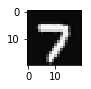

In [84]:
fig = plt.figure(figsize=(1,1))
plt.imshow(np.reshape(Mnist_df_train_data[:,:-1][2],[20,20]).T,cmap='gray')
print (Mnist_df_train_data[2][-1])

In [85]:
## Label set - containing unique labels
Mnist_df_train_label_uq = set(Mnist_df.values[:,400].astype(int))

In [86]:
## Being used for this assignment
def label_dict_gen(label_set): ## Useful for scaling if  huge number of labels (both number and string)
    label_dict = {}
    count = 0
    for label in label_set:
        label_dict[label]=count
        count +=1
    return label_dict

In [87]:
def sigmoid(data):
    return 1/(1+np.exp(-data))

In [88]:
def softmax_prediction(data):
    result= np.exp(data) / np.sum(np.exp(data-np.max(data)), axis=1, keepdims=True)
    return result ## The max proability per coloumn(each coloumn represents a record , and 
                                         ## The complete result matrix to calculate the loss

In [89]:
def forward_prop(data,weights_list):
    hidden_input = np.dot(data[:,:-1],weights_list[0])+weights_list[1]
    hidden_output = sigmoid(hidden_input)
    #hidden_output = np.c_[np.ones((hidden_output.shape[0] ,1)),hidden_output]## Add 1 for the bias
    output_before_softmax = np.dot(hidden_output,weights_list[2])+weights_list[3]
    softmax_output = softmax_prediction(output_before_softmax)
    return softmax_output

In [90]:
def Backward_prop(data,initial_weights,label_dict,learning_rate):
    hidden_input = np.dot(data[:,:-1],initial_weights[0])+initial_weights[1]
    hidden_output = sigmoid(hidden_input)
    #hidden_output = np.c_[np.ones((hidden_output.shape[0] ,1)),hidden_output]## Add 1 for the bias
    output_before_softmax = np.dot(hidden_output,initial_weights[2])+initial_weights[3]
    softmax_output = softmax_prediction(output_before_softmax)
    
    label_general = [label_dict[label] for label in data[:,-1]]
    label_general = np.asarray(label_general)
    
    #print ("label",label_general)
    ## Andrej Karpathy Course calcualting the product of softmax with autoencodin to give the cross-entropy array                 
    corect_logprobs = -np.log(softmax_output[range(softmax_output.shape[0]),label_general])
    ## Sum the individual terms of output of autoencoding snd softmax in the above step and average it
    loss = np.sum(corect_logprobs)/softmax_output.shape[0]    
    
  # compute the gradient on scores
    dsoftmax = softmax_output
    dsoftmax[range(softmax_output.shape[0]),label_general] -= 1 ## Very elegant only the element with true label is updated
    dsoftmax /= softmax_output.shape[0]
    
  # backpropate the gradient to the 2nd layer weight
    dW1 = np.dot(hidden_output.T, dsoftmax)
    db1 = np.sum(dsoftmax, axis=0, keepdims=True)
    
  # perform a parameter update
    gradient_descent(initial_weights[2],dW1,learning_rate)
    gradient_descent(initial_weights[3],db1,learning_rate)
    
    
    dlast = np.dot(dsoftmax,initial_weights[2].T)
    dsigmoid = np.multiply(hidden_output,(1-hidden_output))
    dhidden = np.multiply(dlast,dsigmoid)
    
  # Backpropagate the gradient to 1st layer weights
    dW0 = np.dot(data[:,:-1].T,dhidden)
    db0 = np.sum(dhidden, axis=0, keepdims=True)
    
  # perform a parameter update
    gradient_descent(initial_weights[0],dW0,learning_rate)
    gradient_descent(initial_weights[1],db0,learning_rate)
    return loss

In [91]:
def gradient_descent(weights,gradient,learning_rate):
    weights += -learning_rate * gradient

In [92]:
def SGD(training_data, epochs, mini_batch_size,initial_weights,Loss_graph,learning_rate = .01):
        n = training_data.shape[0]
        print ("For Learning Rate" ,learning_rate )
        for epoch in range(epochs):
            if mini_batch_size<n :
                np.random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size]for k in range(0, n, mini_batch_size)]
            #print (len(mini_batches))
            for mini_batch in mini_batches:
                ## Loss gets updated with each batch and after the loop ends , the loss reflects the loss at end of 1 epoch
                Loss = Backward_prop(mini_batch,initial_weights,label_dict,learning_rate)
                #print (mini_batch[:,-1])
                #break
            #break
            if epoch % 1000== 0:
                Loss_graph[learning_rate].append([Loss,epoch])
                print ("iteration %d: loss %f" % (epoch, Loss))
                softmax_output = forward_prop(training_data,initial_weights)
                prediction = np.argmax(softmax_output, axis=1)
                label_general = [label_dict_gen(Mnist_df_train_label_uq)[label] for label in training_data[:,-1]]
                label_general = np.asarray(label_general)
                print(prediction,label_general)
                accuracy = np.mean(prediction == label_general)
                print ('training accuracy: %.4f' % accuracy)
                #if accuracy>0.95  :
                    #break
                

In [93]:
h = 25 # size of hidden layer
features = 400 # dimensionality
classes = 10 # number of classes
np.random.seed(1)
label_dict = label_dict_gen(Mnist_df_train_label_uq)
learning_rate_list = [.01,.1,1]

In [ ]:
## Doing this for Full Batch
Loss_graph_AllData = defaultdict(list)
batch_size = 3500
epochs_full = 10000
Weights_basedOn_Learning_Rate_fullbatch = defaultdict(list)
## Doing this for Full Batch
for learning_rate in learning_rate_list:
    W0 = 0.01 * np.random.randn(features,h)
    b0 = np.zeros((1,h))
    W1 = 0.01 * np.random.randn(h,classes)
    b1 = np.zeros((1,classes))
    initial_weights = [W0,b0,W1,b1]
    SGD(Mnist_df_train_data, epochs_full, batch_size,initial_weights,Loss_graph_AllData,learning_rate)
    Weights_basedOn_Learning_Rate_fullbatch[learning_rate] = initial_weights

In [ ]:
# ## Doing this for mini Batch
# Loss_graph_stochastic = defaultdict(list)
# batch_size = 3500
# epochs_stochastic = 100000
# Weights_basedOn_Learning_Rate = defaultdict(list)
# np.random.seed(1)
# for learning_rate in learning_rate_list:
#     W0_mini =  .01 * np.random.randn(features,h)
#     b0_mini = np.zeros((1,h))
#     W1_mini =  .01 * np.random.randn(h,classes)
#     b1_mini = np.zeros((1,classes))
#     initial_weights_mini = [W0_mini,b0_mini,W1_mini,b1_mini]
#     SGD(Mnist_df_train_data, epochs_stochastic, batch_size,initial_weights_mini,Loss_graph_stochastic,learning_rate)
#     Weights_basedOn_Learning_Rate[learning_rate]=initial_weights_mini

In [95]:
softmax_output_train = forward_prop(Mnist_df_train_data,Weights_basedOn_Learning_Rate_fullbatch[1])
label_general_train = [label_dict[label] for label in Mnist_df_train_data[:,-1]]
label_general_train = np.asarray(label_general_train)
prediction_train = np.argmax(softmax_output_train, axis=1)
print (prediction_train,label_general_train)
print ('Training_accuracy: %.2f' % (np.mean(prediction_train == label_general_train)))

[5 9 7 ... 0 5 2] [5 9 7 ... 0 5 2]
Training_accuracy: 1.00


In [96]:
softmax_output_test = forward_prop(Mnist_df_test_data,Weights_basedOn_Learning_Rate_fullbatch[1])
label_general_test = [label_dict[label] for label in Mnist_df_test_data[:,-1]]
label_general_test = np.asarray(label_general_test)
prediction_test = np.argmax(softmax_output_test, axis=1)
print (prediction_test,label_general_test)
print ('Testing_accuracy: %.2f' % (np.mean(prediction_test == label_general_test)))

[9 5 5 ... 1 7 0] [9 6 5 ... 1 7 0]
Testing_accuracy: 0.92


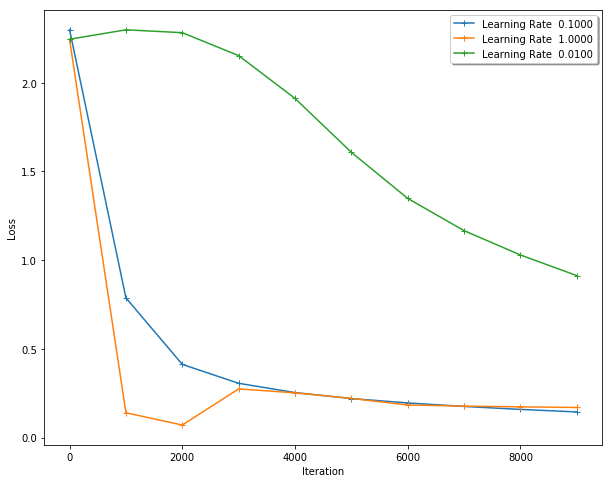

In [97]:
fig = plt.figure(figsize=(10,8))
plt.ylabel('Loss')
plt.xlabel('Iteration')
for key, value in Loss_graph_AllData.items():
    arrayvalue = np.asarray(value)
    plt.plot(arrayvalue[:,1],arrayvalue[:,0],'-+',label="Learning Rate % 0.4f" %key)
    legend = plt.legend(loc='upper right', shadow=True)